<a href="https://colab.research.google.com/github/goose888/powerful_shells/blob/master/01_deepLearning/01_introduction_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Deep Learning
Author: Marieme Ngom, adapting materials from Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to deep learning through a hands-on classification problem using the MNIST dataset.

In particular, we will introduce neural networks and how to train and improve their learning capabilities. We will build up the code by hand and provide exercises. We will use theKeras API (included in the TensorFlow library)
<img src="https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/01_deepLearning/images/mnist_task.png?raw=1"  align="left"/>



In [1]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits.

Note that downloading it the first time might take some time.
The data is split as follows:
- The training data x_train of size $(60000, 28, 28)$  and the corresponding classes ($"0", "1", ... "9"$) in y_train which is a $60000$ dimensional vector,
- The test data x_test of size $(10000, 28*28)$  and the corresponding classes in y_test which is a $10000$ dimensional vector

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:

x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

print()
print('MNIST data loaded: train:',len(x_train),'test:',len(x_test))
print('X_train:', x_train.shape)
print('y_train:', y_train.shape)
print('X_test:', x_test.shape)
print('Y_test:', y_test.shape)


MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 28, 28)
y_train: (60000,)
X_test: (10000, 28, 28)
Y_test: (10000,)


Let's take a closer look. Here are the first 10 training digits:

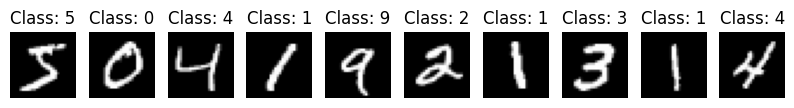

In [4]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(x_train[i,:], (28, 28)), cmap="gray")
    plt.title('Class: '+str(y_train[i]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
We start by training a simple linear.


 <img src="https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/01_deepLearning/images/LinearModel_1.png?raw=1"  align="center"/>



In keras, linear layers are given by Dense() which performs a basic $xW + b$ with an optional nonlinearity applied ("activation function"). The Dense layer connects each input to each output with some weight parameter. They are also called "fully connected."


In [5]:
class LinearClassifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.relu):
        tf.keras.models.Model.__init__(self)

        self.layer_1 = tf.keras.layers.Dense(10, activation='softmax')


    def call(self, inputs):
        # First, we need to convert the input image to a vector by using
        #\textbf{Flatten()}. For the mnist, it means the second dimension $28*28$ becomes $784$.
        x = tf.keras.layers.Flatten()(inputs)


        # Here, we add a \textbf{Dense} layer that has $28 \times 28 = 784$ input nodes
        #(one for each pixel in the input image) and $10$ output nodes (one for each class).

        x = self.layer_1(x)

        return x

# We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). A popular example is the Mean Squared Error (MSE): $MSE = \frac{1}{n}\sum_{i =1}^n (Y_i - \hat{Y}_i)^2$

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc.

- A metric such as "accuracy" to be evaluated.

Here we select sparse categorical crossentropy as the loss function, the stochastic gradient descent as the optimizer, add accuracy to the list of metrics to be evaluated, and compile() the model.

In [6]:
linear_model = LinearClassifier()

linear_model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])

# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function wrt the parameters of the network
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.
The learning rate controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs:

Image source: [saugatbhattarai](https://saugatbhattarai.com.np/what-is-gradient-descent-in-machine-learning/learning-rate-gradient-descent/)
<img src="https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/01_deepLearning/images/lr.jpeg?raw=1" width="500" hight="500" align="center"/>


- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from each individual example but takes longer to train. A larger batch size trains faster but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  

- The choice of batch size and learning are important for performance, generalization and accuracy in distributed deep learning.
- An epoch means one pass through the whole training data. Using few epochs can lead to underfitting and using too many can ead to overfitting.

For far more information, and some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

Here is a concise way to train the network. The fit function handles looping over the batches.
You can run the code below multiple times and it will continue the training process from where it left off. If you want to start from scratch, re-initialize the model using the code a few cells ago.

In [9]:
%%time

epochs = 30
batch_size = 256

history = linear_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2)

Epoch 1/30
235/235 - 1s - loss: 0.3308 - accuracy: 0.9081 - 555ms/epoch - 2ms/step
Epoch 2/30
235/235 - 1s - loss: 0.3300 - accuracy: 0.9080 - 558ms/epoch - 2ms/step
Epoch 3/30
235/235 - 1s - loss: 0.3292 - accuracy: 0.9081 - 580ms/epoch - 2ms/step
Epoch 4/30
235/235 - 1s - loss: 0.3285 - accuracy: 0.9083 - 877ms/epoch - 4ms/step
Epoch 5/30
235/235 - 1s - loss: 0.3278 - accuracy: 0.9084 - 1s/epoch - 4ms/step
Epoch 6/30
235/235 - 1s - loss: 0.3270 - accuracy: 0.9087 - 1s/epoch - 5ms/step
Epoch 7/30
235/235 - 1s - loss: 0.3263 - accuracy: 0.9090 - 939ms/epoch - 4ms/step
Epoch 8/30
235/235 - 1s - loss: 0.3257 - accuracy: 0.9089 - 872ms/epoch - 4ms/step
Epoch 9/30
235/235 - 1s - loss: 0.3250 - accuracy: 0.9094 - 778ms/epoch - 3ms/step
Epoch 10/30
235/235 - 1s - loss: 0.3243 - accuracy: 0.9099 - 612ms/epoch - 3ms/step
Epoch 11/30
235/235 - 1s - loss: 0.3237 - accuracy: 0.9097 - 733ms/epoch - 3ms/step
Epoch 12/30
235/235 - 1s - loss: 0.3231 - accuracy: 0.9101 - 838ms/epoch - 4ms/step
Epoch 1

# Inference

For a better measure of the quality of the model, let's see the model accuracy for the test data.



In [10]:
linscores = linear_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (linear_model.metrics_names[1], linscores[1]*100))

313/313 - 1s - loss: 0.3027 - accuracy: 0.9158 - 536ms/epoch - 2ms/step
accuracy: 91.58%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [23]:
def show_failures(predictions, trueclass=None, predictedclass=None, maxtoshow=20):
    rounded = numpy.argmax(predictions, axis=1)
    errors = rounded!=y_test
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parenthesis.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(x_test.shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            if trueclass is not None and y_test[i] != trueclass:
                continue
            if predictedclass is not None and rounded[i] != predictedclass:
                continue
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(x_test[i,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], y_test[i]))
            ii = ii + 1

Here are the first 10 test images the linear model classified to a wrong class:



313/313 [==============================] - 0s 1ms/step
Showing max 20 first failures. The predicted class is shown first and the correct class in parenthesis.


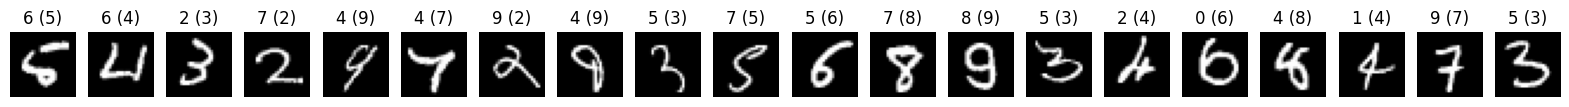

In [24]:
linpredictions = linear_model.predict(x_test)

show_failures(linpredictions)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Nonlinear Model
To improve the model, we often need to add nonlinearities
<img src="https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/01_deepLearning/images/shallow_nn.png?raw=1"  align="left"/>

The output of the NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex task. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/01_deepLearning/images/activation.jpeg?raw=1"  align="center"/>

 and more layers to obtain a deep neural network:
<img src="https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/01_deepLearning/images/deep_nn.png?raw=1"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data. To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in Keras. Dropout() performs the dropout operation mentioned earlier

In [13]:
class NonlinearClassifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.layer_1 = tf.keras.layers.Dense(50, activation='relu')

        self.layer_2 = tf.keras.layers.Dense(50, activation='relu')
        self.drop_3 = tf.keras.layers.Dropout(0.2)
        self.layer_4 = tf.keras.layers.Dense(50, activation='relu')
        self.drop_5 = tf.keras.layers.Dropout(0.2)

        # The last layer needs to be like this:
        self.layer_out = tf.keras.layers.Dense(10, activation='softmax')


    def call(self, inputs):

        x = tf.keras.layers.Flatten()(inputs)
        x = self.layer_1(x)

        # The more complex version:
        x = self.layer_2(x)
        x = self.drop_3(x)
        x = self.layer_4(x)
        x = self.drop_5(x)

        x = self.layer_out(x)

        return x

In [14]:
nonlinear_model = NonlinearClassifier()

nonlinear_model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])

In [20]:
%%time

epochs = 30
batch_size = 256

history = nonlinear_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2)

Epoch 1/30
235/235 - 1s - loss: 0.1003 - accuracy: 0.9717 - 1s/epoch - 5ms/step
Epoch 2/30
235/235 - 1s - loss: 0.1003 - accuracy: 0.9707 - 1s/epoch - 4ms/step
Epoch 3/30
235/235 - 1s - loss: 0.0988 - accuracy: 0.9718 - 961ms/epoch - 4ms/step
Epoch 4/30
235/235 - 1s - loss: 0.0990 - accuracy: 0.9711 - 977ms/epoch - 4ms/step
Epoch 5/30
235/235 - 1s - loss: 0.0964 - accuracy: 0.9722 - 1s/epoch - 4ms/step
Epoch 6/30
235/235 - 2s - loss: 0.0978 - accuracy: 0.9712 - 2s/epoch - 7ms/step
Epoch 7/30
235/235 - 2s - loss: 0.0982 - accuracy: 0.9712 - 2s/epoch - 6ms/step
Epoch 8/30
235/235 - 1s - loss: 0.0960 - accuracy: 0.9722 - 968ms/epoch - 4ms/step
Epoch 9/30
235/235 - 1s - loss: 0.0949 - accuracy: 0.9731 - 956ms/epoch - 4ms/step
Epoch 10/30
235/235 - 1s - loss: 0.0946 - accuracy: 0.9725 - 1s/epoch - 4ms/step
Epoch 11/30
235/235 - 1s - loss: 0.0947 - accuracy: 0.9725 - 975ms/epoch - 4ms/step
Epoch 12/30
235/235 - 1s - loss: 0.0934 - accuracy: 0.9729 - 940ms/epoch - 4ms/step
Epoch 13/30
235/235

In [21]:
nonlinscores = nonlinear_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (nonlinear_model.metrics_names[1], nonlinscores[1]*100))

313/313 - 1s - loss: 0.0927 - accuracy: 0.9743 - 875ms/epoch - 3ms/step
accuracy: 97.43%


313/313 [==============================] - 1s 2ms/step
Showing max 20 first failures. The predicted class is shown first and the correct class in parenthesis.


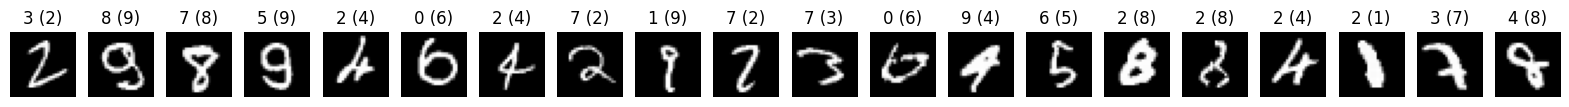

In [25]:
nonlinpredictions = nonlinear_model.predict(x_test)

show_failures(nonlinpredictions)

In [26]:
print(nonlinear_model.summary())

Model: "nonlinear_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             multiple                  39250     
                                                                 
 dense_2 (Dense)             multiple                  2550      
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  2550      
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_4 (Dense)             multiple                  510       
                                                                 
Total params: 44,860
Trainable params: 44,860


Exercise:
1. Compile, fit and predict using NonlinearClassifier()

